Сталь – один из важнейших строительных материалов современности. Стальные здания устойчивы к естественному и искусственному износу, что сделало этот материал повсеместно распространенным во всем мире. Чтобы сделать производство стали более эффективным, этот конкурс поможет выявить дефекты.


ссылка на каггл с этим соревнованием - https://www.kaggle.com/c/severstal-steel-defect-detection

### Постановка задачи :

Этот конкурс представляет собой двойной конкурс: классифицируйте тип дефекта стали, а также сегментируйте части изображения, содержащие дефект.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout

In [2]:
data = pd.read_csv('d://GB//severstal-steel-defect-detection/train.csv')

In [3]:
data

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [4]:
data.shape

(7095, 3)

У нас 7095 и три фичи

# Разведочный анализ данных

ClassId
3    5150
1     897
4     801
2     247
Name: count, dtype: int64

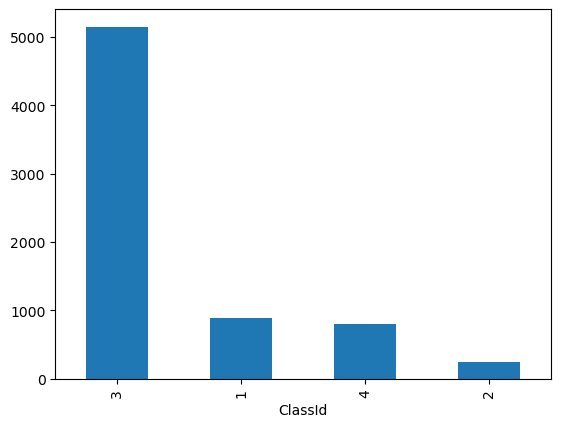

In [5]:
data["ClassId"].value_counts().plot(kind = 'bar')
data["ClassId"].value_counts()

больше всего меток третьего класса

Перекос данных, поэтому выполним аугментацию.

In [6]:
import cv2

In [7]:
l1=[]
l2=[]
for img,ClassId,EncodedPixels in tqdm(data.values):
    image=cv2.imread("d://GB/severstal-steel-defect-detection/train_images/{}".format(img),cv2.IMREAD_COLOR)
    image=cv2.resize(image,(120,120))
    l1.append(image)
    l2.append(ClassId)

100%|█████████████████████████████████████████████████████████████████████████████| 7095/7095 [00:24<00:00, 287.37it/s]


Проверка изображений случайной стали, чтобы проверить, дефектна ли она или нет.

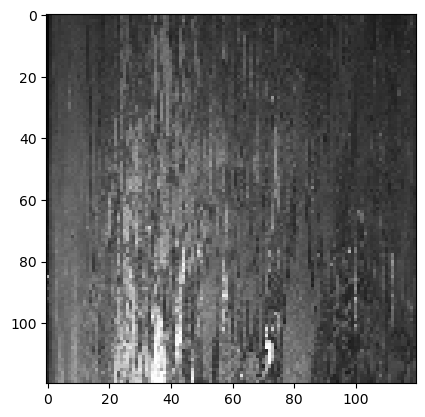

In [8]:
i = 15
plt.imshow(l1[i])

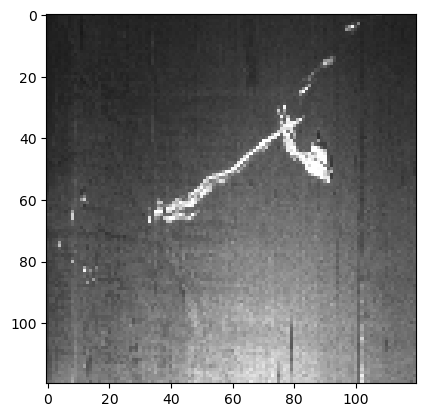

In [9]:
i = 16
plt.imshow(l1[i])

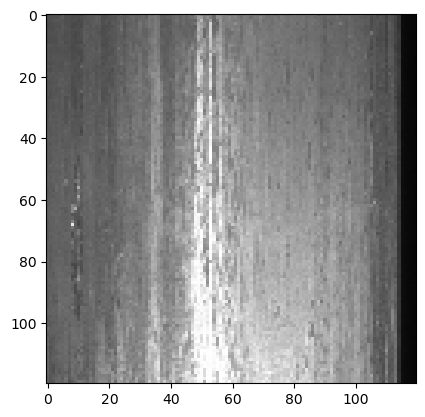

In [10]:
i = 90
plt.imshow(l1[i])

Выполним one-hot кодировку

In [11]:
encoder = LabelEncoder()

X= np.array(l1)
X = X/255

y = encoder.fit_transform(l2)
y = np.array(y)


In [12]:
X.shape

(7095, 120, 120, 3)

In [13]:
y.shape

(7095,)

# Борьба с дибалансом

для борьбы с дисбалансом выполним случайное сэмплирование

In [14]:
from imblearn.over_sampling import RandomOverSampler
reshaped_X = X.reshape(X.shape[0],-1)
oversample = RandomOverSampler(sampling_strategy='not majority')
X, y  = oversample.fit_resample(reshaped_X , y)
X = X.reshape(-1,120,120,3)

In [15]:
X.shape

(20600, 120, 120, 3)

In [16]:

y = to_categorical(y)

In [17]:
y

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

разделим на тренировку и валидацию

In [18]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True)

In [19]:
print("x_train размер:",X_train.shape)
print("x_test размер:",X_test.shape)
print("y_train размер:",y_train.shape)
print("y_test размер:",y_test.shape)

x_train размер: (16480, 120, 120, 3)
x_test размер: (4120, 120, 120, 3)
y_train размер: (16480, 4)
y_test размер: (4120, 4)


# Построение нейронной сети  в 3 слоя и график обучения

In [56]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model.add(Flatten())
model.add(Dense(4,activation="softmax"))

In [57]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [58]:
history = model.fit(X_train,y_train,epochs=20,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

Epoch 1/20
129/129 [==============================] - 12s 94ms/step - loss: 1.5790 - accuracy: 0.6187 - val_loss: 0.6353 - val_accuracy: 0.7294
Epoch 2/20
129/129 [==============================] - 11s 89ms/step - loss: 0.4758 - accuracy: 0.8385 - val_loss: 0.4231 - val_accuracy: 0.8580
Epoch 3/20
129/129 [==============================] - 11s 88ms/step - loss: 0.3214 - accuracy: 0.9029 - val_loss: 0.3428 - val_accuracy: 0.8995
Epoch 4/20
129/129 [==============================] - 11s 88ms/step - loss: 0.2507 - accuracy: 0.9294 - val_loss: 0.3331 - val_accuracy: 0.8883
Epoch 5/20
129/129 [==============================] - 11s 89ms/step - loss: 0.2094 - accuracy: 0.9448 - val_loss: 0.3054 - val_accuracy: 0.9027
Epoch 6/20
129/129 [==============================] - 11s 89ms/step - loss: 0.1908 - accuracy: 0.9484 - val_loss: 0.2853 - val_accuracy: 0.9214
Epoch 7/20
129/129 [==============================] - 12s 90ms/step - loss: 0.1879 - accuracy: 0.9485 - val_loss: 0.2677 - val_accuracy:

<Axes: title={'center': 'Loss curve'}>

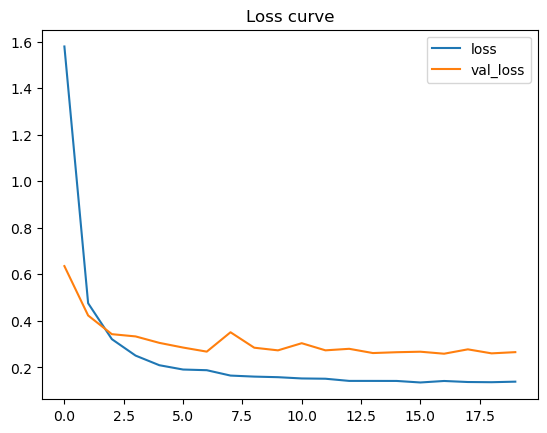

In [59]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

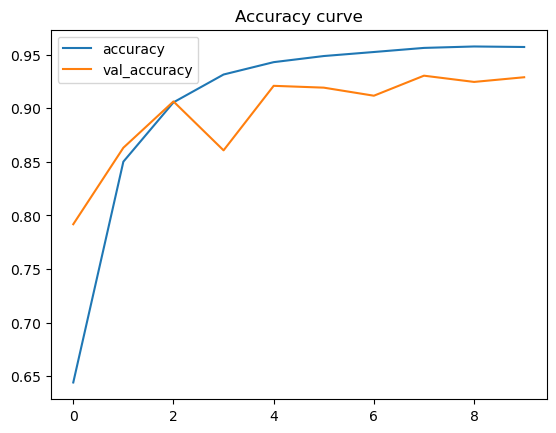

In [24]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

# Построение нейронной сети  в 5 слоев

In [25]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))


In [26]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [27]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

Epoch 1/10
129/129 [==============================] - 19s 141ms/step - loss: 1.0600 - accuracy: 0.5875 - val_loss: 0.6767 - val_accuracy: 0.7291
Epoch 2/10
129/129 [==============================] - 17s 135ms/step - loss: 0.6102 - accuracy: 0.7695 - val_loss: 0.5069 - val_accuracy: 0.8136
Epoch 3/10
129/129 [==============================] - 17s 135ms/step - loss: 0.4655 - accuracy: 0.8337 - val_loss: 0.4376 - val_accuracy: 0.8362
Epoch 4/10
129/129 [==============================] - 17s 135ms/step - loss: 0.3703 - accuracy: 0.8737 - val_loss: 0.3955 - val_accuracy: 0.8437
Epoch 5/10
129/129 [==============================] - 18s 138ms/step - loss: 0.3005 - accuracy: 0.8974 - val_loss: 0.3502 - val_accuracy: 0.8782
Epoch 6/10
129/129 [==============================] - 18s 136ms/step - loss: 0.2544 - accuracy: 0.9201 - val_loss: 0.3093 - val_accuracy: 0.9022
Epoch 7/10
129/129 [==============================] - 17s 135ms/step - loss: 0.2225 - accuracy: 0.9301 - val_loss: 0.4620 - val_ac

<Axes: title={'center': 'Loss curve'}>

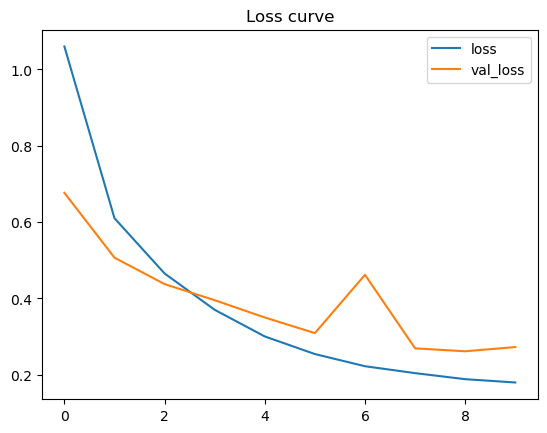

In [28]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

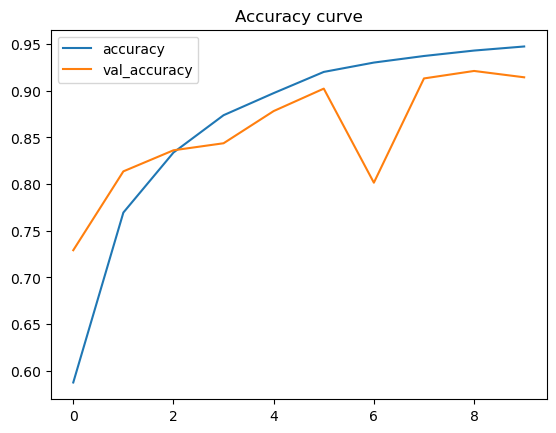

In [29]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

# Построение нейронной сети в 13 слоев и обучение

In [31]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))

In [ ]:
# early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,min_delta=0.001,restore_best_weights=True)

Сборка и обучение модели

In [32]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [33]:
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

Epoch 1/10
129/129 [==============================] - 16s 120ms/step - loss: 1.0119 - accuracy: 0.5339 - val_loss: 0.8399 - val_accuracy: 0.6369
Epoch 2/10
129/129 [==============================] - 15s 114ms/step - loss: 0.7973 - accuracy: 0.6706 - val_loss: 0.6993 - val_accuracy: 0.7223
Epoch 3/10
129/129 [==============================] - 15s 114ms/step - loss: 0.7332 - accuracy: 0.7029 - val_loss: 0.6462 - val_accuracy: 0.7490
Epoch 4/10
129/129 [==============================] - 15s 115ms/step - loss: 0.6436 - accuracy: 0.7469 - val_loss: 0.5859 - val_accuracy: 0.7718
Epoch 5/10
129/129 [==============================] - 15s 117ms/step - loss: 0.5690 - accuracy: 0.7819 - val_loss: 0.4922 - val_accuracy: 0.8160
Epoch 6/10
129/129 [==============================] - 15s 115ms/step - loss: 0.5063 - accuracy: 0.8086 - val_loss: 0.4544 - val_accuracy: 0.8245
Epoch 7/10
129/129 [==============================] - 15s 114ms/step - loss: 0.4545 - accuracy: 0.8280 - val_loss: 0.4333 - val_ac

# Анализ результатов обучения

<Axes: title={'center': 'Loss curve'}>

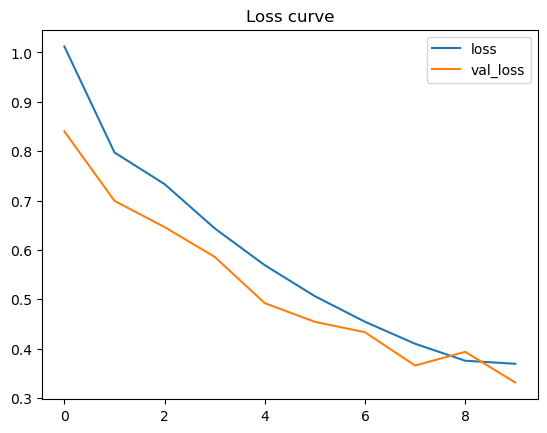

In [34]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

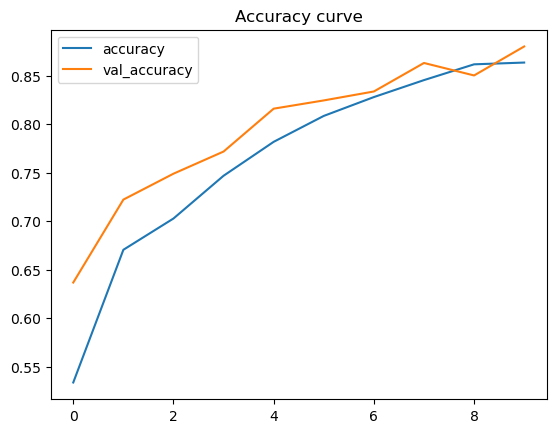

In [35]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

In [36]:
result = model.evaluate(X_test, y_test)

loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

129/129 [==============================] - 1s 10ms/step - loss: 0.3316 - accuracy: 0.8801
[+] Accuracy: 88.01%


In [44]:
from keras.models import Model
model.save('d://GB/severstal-steel-defect-detection/my_model.keras')

In [45]:
from keras.models import load_model

loaded_model = load_model('d://GB/severstal-steel-defect-detection/my_model.keras')


# Архитектура созданной нейронной сети

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 39, 39, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 2, 2, 64)         

# Тестирование на новых примерах

In [47]:
l2[:3]

[1, 3, 1]

In [48]:
X= np.array(l1[:3])
X = X/255

y = encoder.fit_transform(l2[:3])
y = np.array(y)

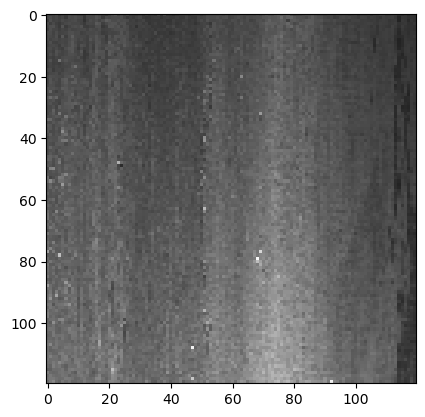

In [49]:
plt.imshow(l1[0]);

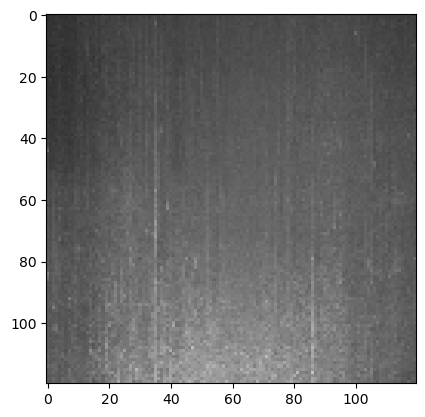

In [50]:
plt.imshow(l1[1]);

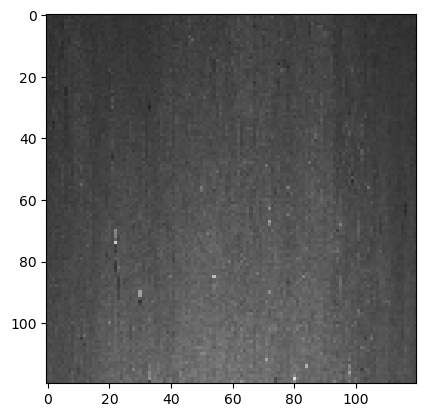

In [51]:
plt.imshow(l1[2]);

In [52]:
y =  to_categorical(y)
y

array([[1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [53]:

predictions = model.predict(X)
predictions

1/1 [==============================] - 0s 175ms/step


array([[9.4027555e-01, 2.2151363e-03, 5.7460051e-02, 4.9321789e-05],
       [3.9403561e-01, 3.9315398e-04, 5.9934872e-01, 6.2224120e-03],
       [8.6427331e-01, 9.1723638e-04, 1.3314550e-01, 1.6639209e-03]],
      dtype=float32)

Здесь три эксперимента, где мы видим, что тест № 2 был с меткой 3, но неверно идентифицировался как метка 1.

In [54]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 39, 39, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 2, 2, 64)         

# описание архитектуры нейронной сети

У нас тут многослойная нейронная сеть с разными типами слоев.

теперь по поводу слоев нейронной сети и их особенностей.

1 слой - Conv2D. Он используется для выполнения двумерной свертки входных данных. Он применяет набор фильтров к входному изображению или карте объектов, перемещая их по входным данным и вычисляя скалярное произведение в каждом месте. Эта операция позволяет слою извлекать объекты и фиксировать пространственные отношения во входных данных. Уровень Conv2D обычно используется в сверточных нейронных сетях (CNN) для таких задач, как классификация изображений, обнаружение объектов и сегментация изображений.

2 слой - MaxPooling2D.  Это  операция понижающей дискретизации, которая уменьшает пространственные размеры (ширину и высоту) входного изображения или карты объектов. Он делит входные данные на непересекающиеся прямоугольники и выводит максимальное значение внутри каждого прямоугольника. Это помогает извлечь наиболее важные функции и снизить вычислительные требования для последующих слоев.

Далее эти слои повторяются еще 2 раза.

7 слой - Flatten. он преобразует входной тензор в одномерный массив, эффективно выравнивая его. Он принимает многомерный входной тензор, например двумерное изображение, и преобразует его в одномерный вектор, который можно использовать в качестве входных данных для полностью связного слоя или любого другого слоя, который ожидает одномерных входных данных.

8 слой - Dense. это полностью связный слой, который соединяет каждый нейрон предыдущего слоя с каждым нейроном текущего слоя. Он выполняет линейную операцию над входными данными, за которой следует функция активации, позволяющая сети изучать сложные закономерности и взаимосвязи в данных. Количество нейронов в плотном слое определяет размерность вывода.

9 cлой - Dropout. это метод регуляризации, используемый для уменьшения переобучения в нейронных сетях. Он случайным образом устанавливает для части входных единиц значение 0 на каждом этапе обучения, что помогает предотвратить слишком большую зависимость сети от конкретных функций или корреляций. Dropout улучшает способность модели к обобщению за счет внесения шума во время обучения и побуждает сеть изучать более надежные и независимые представления.

Далее слои повторяются.

В итоге в данной нейронной сети 12 различных слоев, и 139 780 параметров.